In [4]:
import csv
import re
import os
import sys
csv.field_size_limit(sys.maxsize)
# Input CSVs (adjust paths as needed)
CSV_FILES = [
    "/Users/mohamadashraf/Desktop/Projects/Jenny/oss_quality.csv",
    "/Users/mohamadashraf/Desktop/Projects/Jenny/oss4sg_quality.csv"
]

# Output suffix (you can customize)
OUTPUT_SUFFIX = "_parsed.csv"

# Columns we want in the final CSV
NEW_COLUMNS = [
    "repo_name",
    "problems_total",
    "critical_issues",
    "high_issues",
    "moderate_issues",
    "low_issues",
    "problems"
]

def parse_console_output(console_text):
    """
    Parse the Qodana console output and extract:
      1) problems_total
      2) critical_issues
      3) high_issues
      4) moderate_issues
      5) low_issues
      6) problems -> list of (problem_name, count)

    We’ll do a best-effort approach:
      - Sum up any "Analysis results: N problems detected" occurrences
      - Sum up the "By severity: Critical - X, High - Y, etc." occurrences
      - Parse any tables that appear under headings like "Qodana - Detailed summary",
        "Qodana - Problems examples", or "Qodana - Sanity summary" and collect 
        problem names + counts.
    
    If fields aren't found, default them to 0 or empty.
    """

    # We might have multiple summary sections, so we accumulate totals
    total_problems = 0
    severity_counts = {
        "Critical": 0,
        "High": 0,
        "Moderate": 0,
        "Low": 0,
    }
    problem_map = {}  # key=problem name, value=accumulated count

    # ------------------------------------------------------------------
    # 1) Find every "Analysis results: X problems detected"
    #    We'll sum them up if there are multiple sections.
    # ------------------------------------------------------------------
    analysis_results_pattern = re.compile(
        r"Analysis results:\s+(\d+)\s+problems detected"
    )
    for match in analysis_results_pattern.finditer(console_text):
        count_str = match.group(1)
        total_problems += int(count_str)

    # ------------------------------------------------------------------
    # 2) Find every "By severity: Critical - X, High - Y, ..."
    #    We’ll sum them across multiple sections.
    # ------------------------------------------------------------------
    severity_pattern = re.compile(
        r"By severity:\s*([^\n]+)"
    )
    for match in severity_pattern.finditer(console_text):
        line = match.group(1)  # e.g. "High - 70, Moderate - 227"
        # We look for patterns like "Critical - 123", "High - 70", etc.
        chunk_pattern = re.compile(r"(Critical|High|Moderate|Low)\s*-\s*([\d,]+)")
        chunk_matches = chunk_pattern.findall(line)
        for sev, val in chunk_matches:
            # remove commas from val
            val = val.replace(",", "")
            severity_counts[sev] += int(val)

    # ------------------------------------------------------------------
    # 3) Parse any tables that list problem names + severity + counts
    #
    #   Typically we see lines like:
    #       Name                                                Severity  Problems count
    #       ---------------------------------------------------------------------------
    #       Errors in string formatting operations                  High              21
    #
    #   We'll look for lines with the pattern:
    #       ^(.+?)\s{2,}(Critical|High|Moderate|Low)\s{2,}(\d+)$
    #
    #   or lines with "File <something>  Some inspection  Severity   Count"
    # ------------------------------------------------------------------
    table_line_pattern = re.compile(
        r"^(.+?)\s{2,}(Critical|High|Moderate|Low)\s{2,}(\d+)$",
        re.MULTILINE
    )
    table_matches = table_line_pattern.findall(console_text)
    # Each match is (problem_name, severity, count_str)
    for problem_name, sev, count_str in table_matches:
        # Clean up the problem name a bit
        problem_name = problem_name.strip()
        # Convert count
        count_val = int(count_str.strip())
        # Accumulate in problem_map
        if problem_name not in problem_map:
            problem_map[problem_name] = 0
        problem_map[problem_name] += count_val
        # You could also add to severity_counts[sev] here if needed 
        # but presumably that was covered in "By severity" lines

    # ------------------------------------------------------------------
    # 4) Combine results
    # ------------------------------------------------------------------
    # If we never found "Analysis results: ...", but the "table_line_pattern"
    # found something, you could sum those up as an alternative fallback
    # but that can lead to double counting in some Qodana logs.
    #
    # For safety, if total_problems == 0 but we *do* see problem_map, we could:
    # total_problems = sum(problem_map.values())
    # (comment out or enable if that fits your data better)
    #
    # Here we'll keep it simple:
    if total_problems == 0 and problem_map:
        total_problems = sum(problem_map.values())

    # Build a list of (problem, count) sorted descending by count
    problem_tuples = sorted(problem_map.items(), key=lambda x: x[1], reverse=True)

    # Return the new metrics
    return {
        "problems_total": total_problems,
        "critical_issues": severity_counts["Critical"],
        "high_issues": severity_counts["High"],
        "moderate_issues": severity_counts["Moderate"],
        "low_issues": severity_counts["Low"],
        "problems": problem_tuples
    }


def process_csv(input_path, output_path):
    """
    1) Read the old CSV
    2) Discard columns [problems_total, critical_issues, high_issues, moderate_issues, low_issues]
    3) Parse the console_output to create new columns
    4) Write out the new CSV with the new columns
    """
    # 1) Read the old CSV
    if not os.path.exists(input_path):
        print(f"[ERROR] Input CSV not found: {input_path}")
        return

    # We’ll keep rows in a new structure
    new_rows = []

    with open(input_path, "r", encoding="utf-8") as f_in:
        reader = csv.DictReader(f_in)
        old_fieldnames = reader.fieldnames

        # We expect columns:
        #   repo_name, console_output, problems_total, critical_issues, high_issues, moderate_issues, low_issues
        # We'll keep just repo_name and console_output from the old data
        # and remove the old "xxx_issues" columns.
        for row in reader:
            repo_name = row["repo_name"]
            console_output = row["console_output"]

            # 2) Discard old columns by ignoring them (we won’t copy them to the new row)
            # Actually, we only keep "repo_name" and "console_output" from the old row

            # 3) Parse the console_output
            parsed = parse_console_output(console_output)

            # 4) Create a new row with the new columns
            new_row = {
                "repo_name": repo_name,
                "problems_total": parsed["problems_total"],
                "critical_issues": parsed["critical_issues"],
                "high_issues": parsed["high_issues"],
                "moderate_issues": parsed["moderate_issues"],
                "low_issues": parsed["low_issues"],
                # Convert the list of tuples to a string or keep them as is
                # for example: [("Unbound local variables", 39), ...]
                # We'll store them as a string for CSV
                "problems": str(parsed["problems"])
            }

            new_rows.append(new_row)

    # 5) Write out the new CSV
    with open(output_path, "w", newline="", encoding="utf-8") as f_out:
        writer = csv.DictWriter(f_out, fieldnames=NEW_COLUMNS)
        writer.writeheader()
        writer.writerows(new_rows)

    print(f"[DONE] Processed {input_path}, wrote {len(new_rows)} rows to {output_path}")

def main():
    for csv_file in CSV_FILES:
        base, ext = os.path.splitext(csv_file)
        output_path = base + OUTPUT_SUFFIX
        process_csv(csv_file, output_path)

if __name__ == "__main__":
    main()


[DONE] Processed /Users/mohamadashraf/Desktop/Projects/Jenny/oss_quality.csv, wrote 90 rows to /Users/mohamadashraf/Desktop/Projects/Jenny/oss_quality_parsed.csv
[DONE] Processed /Users/mohamadashraf/Desktop/Projects/Jenny/oss4sg_quality.csv, wrote 187 rows to /Users/mohamadashraf/Desktop/Projects/Jenny/oss4sg_quality_parsed.csv


In [18]:
import pandas as pd

# Paths to the CSV files
oss_csv_path = "/Users/mohamadashraf/Desktop/Projects/Jenny/oss_quality_parsed.csv"
oss4sg_csv_path = "/Users/mohamadashraf/Desktop/Projects/Jenny/oss4sg_quality_parsed.csv"

# Load the datasets
oss_df = pd.read_csv(oss_csv_path)
oss4sg_df = pd.read_csv(oss4sg_csv_path)

# Delete the 'problems_total' column and recalculate it
for df in [oss_df, oss4sg_df]:
    if 'problems_total' in df.columns:
        df.drop(columns=['problems_total'], inplace=True)
    df['problems_total'] = df['critical_issues'] + df['high_issues'] + df['moderate_issues'] + df['low_issues']

# Remove rows where 'problems_total' is 0
oss_df = oss_df[oss_df['problems_total'] > 0]
oss4sg_df = oss4sg_df[oss4sg_df['problems_total'] > 0]



In [19]:
oss_df.head()

,repo_name,critical_issues,high_issues,moderate_issues,low_issues,problems,problems_total
0,BLCM_BLCMods,0,70,227,0,"[('Shadowing names from outer scopes', 190), (...",297
1,Baekalfen_PyBoy,0,1425,1389,0,"[('Statement has no effect', 1359), ('PEP 8 na...",2814
3,BlackArch_blackarch,0,117,78,0,"[('Statement has no effect', 79), ('Unused loc...",195
5,Bukkit_Bukkit,0,193,4,0,"[('Unnecessary modifier', 147), ('Static initi...",197
6,BytomDAO_bytom,16,3696,2353,0,"[('Unhandled error', 1429), ('Usage of Snake_C...",6065


In [20]:

# Calculate average number of problems for each type
oss_avg = oss_df[['critical_issues', 'high_issues', 'moderate_issues', 'low_issues', 'problems_total']].mean()
oss4sg_avg = oss4sg_df[['critical_issues', 'high_issues', 'moderate_issues', 'low_issues', 'problems_total']].mean()

# Display the averages
print("Average number of problems for OSS:")
print(oss_avg)

print("\nAverage number of problems for OSS4SG:")
print(oss4sg_avg)


Average number of problems for OSS:
critical_issues     487.362069
high_issues         728.913793
moderate_issues     446.775862
low_issues            0.000000
problems_total     1663.051724
dtype: float64

Average number of problems for OSS4SG:
critical_issues     412.785235
high_issues        1293.919463
moderate_issues     700.000000
low_issues            0.000000
problems_total     2406.704698
dtype: float64


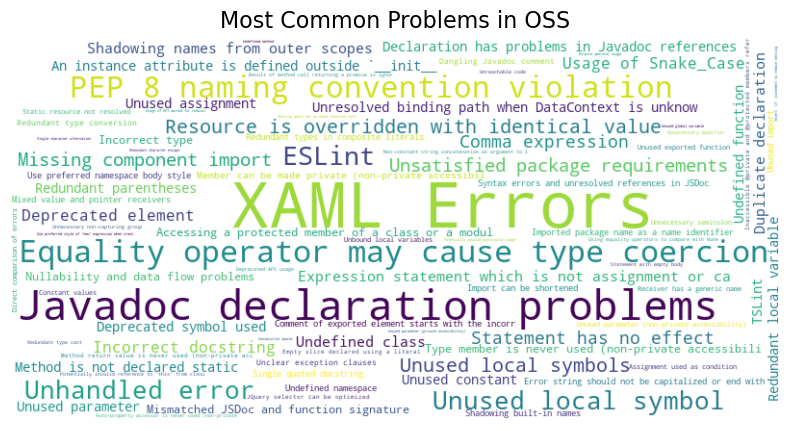

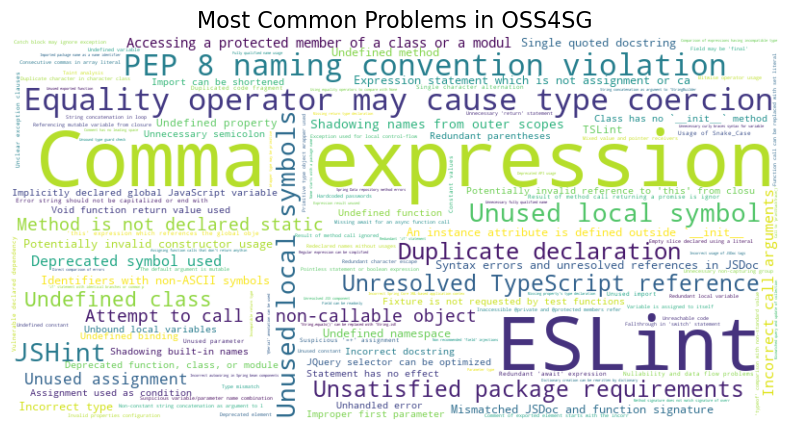

In [24]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def process_problems_and_generate_wordcloud(df, title):
    """
    Processes the problems column, counts occurrences, sorts them, and generates a word cloud.

    :param df: The dataframe containing the 'problems' column.
    :param title: Title for the word cloud.
    """
    # Initialize a Counter to count occurrences of each problem
    problem_counter = Counter()

    # Iterate through the 'problems' column
    for problem_list in df['problems']:
        if pd.notna(problem_list):  # Ensure the column value is not NaN
            # Parse the stringified list into an actual list of tuples if needed
            problem_list = eval(problem_list) if isinstance(problem_list, str) else problem_list
            for problem, count in problem_list:
                problem_counter[problem] += count

    # Sort problems by count in descending order
    sorted_problems = dict(sorted(problem_counter.items(), key=lambda item: item[1], reverse=True))

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(sorted_problems)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.show()

    return sorted_problems

# Assuming oss_df and oss4sg_df are the dataframes for OSS and OSS4SG
oss_problems = process_problems_and_generate_wordcloud(oss_df, "Most Common Problems in OSS")
oss4sg_problems = process_problems_and_generate_wordcloud(oss4sg_df, "Most Common Problems in OSS4SG")


In [29]:

# Display top 5 problems for reference
print("Top 5 Problems in OSS:")
print(dict(list(oss_problems.items())[:10]))

print("\nTop 5 Problems in OSS4SG:")
print(dict(list(oss4sg_problems.items())[:10]))


Top 5 Problems in OSS:
{'XAML Errors': 22555, 'Javadoc declaration problems': 6550, 'Equality operator may cause type coercion': 6488, 'PEP 8 naming convention violation': 6025, 'ESLint': 4496, 'Unused local symbol': 4126, 'Unhandled error': 4021, 'Resource is overridden with identical value': 2203, 'Unused local symbols': 2118, 'Unsatisfied package requirements': 1980}

Top 5 Problems in OSS4SG:
{'Comma expression': 31786, 'ESLint': 29235, 'Equality operator may cause type coercion': 28082, 'PEP 8 naming convention violation': 25497, 'Unused local symbol': 16669, 'JSHint': 16552, 'Unused local symbols': 16117, 'Duplicate declaration': 13216, 'Unresolved TypeScript reference': 11655, 'Unsatisfied package requirements': 11190}


Here’s the explanation of the **10 problems** for **OSS** and **OSS4SG** datasets:

---

### **Top 10 Problems in OSS**

1. **XAML Errors**:
   - Issues in XAML (eXtensible Application Markup Language) files used for defining user interfaces in WPF or Xamarin applications. Common errors include invalid markup, missing attributes, or unsupported controls.

2. **Javadoc Declaration Problems**:
   - Errors in Java documentation comments (Javadoc). These include missing tags like `@param`, `@return`, or improper formatting, which can cause incomplete or misleading documentation.

3. **Equality Operator May Cause Type Coercion**:
   - A JavaScript issue where `==` or `!=` is used, causing implicit type conversion (e.g., `"1" == 1` evaluates to `true`). Use `===` or `!==` to avoid unexpected results.

4. **PEP 8 Naming Convention Violation**:
   - Python code that does not conform to the PEP 8 style guide, such as function names not using `snake_case` or class names not using `PascalCase`.

5. **ESLint**:
   - JavaScript/TypeScript linting issues flagged by ESLint, such as unused variables, incorrect imports, missing semicolons, or inconsistent indentation.

6. **Unused Local Symbol**:
   - Variables, functions, or other symbols are declared but not used anywhere in the code. This is often a sign of dead code or poor maintenance.

7. **Unhandled Error**:
   - Errors in code where exceptions or edge cases are not properly handled. For example, an API call may fail, but the error is not caught or logged.

8. **Resource Is Overridden With Identical Value**:
   - Occurs when a resource (like a variable or configuration setting) is redefined with the same value, leading to redundancy and confusion.

9. **Unused Local Symbols**:
   - Similar to "Unused Local Symbol," but may refer to multiple unused symbols detected in a single file or module.

10. **Unsatisfied Package Requirements**:
   - Dependency issues where a required package or library version does not meet the specified conditions in a project’s configuration (e.g., `requirements.txt` or `package.json`).

---

### **Top 10 Problems in OSS4SG**

1. **Comma Expression**:
   - Found in languages like C or JavaScript, where a comma-separated expression evaluates each part but only returns the last value. This can lead to unclear or unintended behavior.

2. **ESLint**:
   - Similar to OSS, these are linting issues in JavaScript/TypeScript flagged by ESLint.

3. **Equality Operator May Cause Type Coercion**:
   - Same as OSS, this JavaScript issue involves using `==` or `!=` instead of the strict `===` or `!==`.

4. **PEP 8 Naming Convention Violation**:
   - Same as OSS, this refers to violations of Python’s PEP 8 style guide.

5. **Unused Local Symbol**:
   - Same as OSS, variables or functions declared but never used.

6. **JSHint**:
   - General JavaScript issues flagged by JSHint, a linter that checks for errors and potential problems like missing semicolons, unused variables, and syntax inconsistencies.

7. **Unused Local Symbols**:
   - Same as OSS, this refers to multiple unused symbols in a single file or module.

8. **Duplicate Declaration**:
   - Occurs when a variable, function, or class is declared multiple times within the same scope, causing potential conflicts or ambiguity.

9. **Unresolved TypeScript Reference**:
   - Issues in TypeScript files where a type, variable, or module cannot be resolved. This can happen due to incorrect imports or missing type declarations.

10. **Unsatisfied Package Requirements**:
   - Same as OSS, this refers to dependency issues where required packages or libraries do not meet the specified criteria.

---

These explanations should clarify the meaning of the top 10 problems for both datasets. Let me know if you need further assistance!